In [1]:
import sys
print(sys.executable)

/home/fatnaoui/tools/miniforge3/envs/fasttext/bin/python


In [2]:
from datasets import load_dataset
import nltk
from nltk.tokenize import sent_tokenize
from pathlib import Path
from tqdm import tqdm
import json, re

from helpers.filtering import looks_like_clean_spanish, remove_invisible_chars

/home/fatnaoui/tools/miniforge3/envs/fasttext/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download("punkt_tab")

out_file = Path("es_data.jsonl")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/fatnaoui/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
print("Loading Spanich Wikipedia dataset...")
dataset = load_dataset("wikimedia/wikipedia", "20231101.es", split="train", streaming=True)

Loading Spanich Wikipedia dataset...


In [5]:
min_words = 3  # min words in each example
n_sentences = 0
n_articles = 0
n_words = 0
TARGET_ARTICLES = 10     # you can increase later
TARGET_SENTENCES = 30_000
TARGET_WORDS = 10_000

with out_file.open("w", encoding="utf-8") as f_out:
    for example in tqdm(dataset, desc="Processing Spanish articles"):

        article_not_seen = True

        if n_sentences >= TARGET_SENTENCES:
            break

        text = example["text"]
        if not text:
            continue

        # Better: specify Spanish for NLTK
        sentences = sent_tokenize(text, language="spanish")

        for sent in sentences:
            if n_sentences >= TARGET_SENTENCES:
                break

            sent = sent.strip()
            sent = re.sub(r'-{2,}', ' ', sent)
            sent = remove_invisible_chars(sent)

            # Normalize whitespace 
            sent = re.sub(r"\s+", " ", sent)
            
            if not sent:
                continue

            word_count = len(sent.split())
            if word_count < min_words:
                continue

            # ✅ Use the Spanish filter now
            if not looks_like_clean_spanish(sent):
                continue

            # ❌ DO NOT strip to ASCII: we want áéíóúüñ
            # sent = sent.encode("ascii", "ignore").decode("ascii")

            # Normalize: lowercase, keep accents
            sent = sent.lower().replace("\n", " ")

            line = json.dumps({"text": sent}, ensure_ascii=False)
            f_out.write(line + "\n")

            n_words += word_count
            n_sentences += 1
            if article_not_seen:
                n_articles += 1
                article_not_seen = False

print(f"Done. Saved {n_articles} articles, {n_words} words, and {n_sentences} sentences to: {out_file}")


Processing Spanish articles: 258it [00:17, 14.42it/s]

Done. Saved 258 articles, 738620 words, and 30000 sentences to: es_data.jsonl


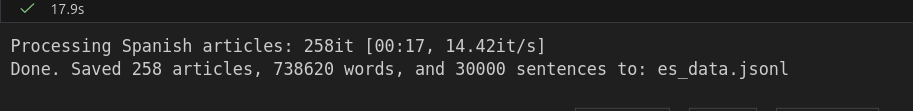
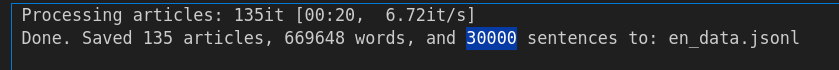

In [7]:
from pathlib import Path
import random

input_path = Path("es_data.jsonl")        # your big file
out_dir = Path("../../MAFT/es")

train_path = out_dir / "train.jsonl"
val_path   = out_dir / "validation.jsonl"
test_path  = out_dir / "test.jsonl"

# ratios: change them if you want
train_ratio = 0.8
val_ratio   = 0.1
test_ratio  = 0.1

random.seed(42)  # for reproducibility

n_train = n_val = n_test = 0

with input_path.open("r", encoding="utf-8") as fin, \
     train_path.open("w", encoding="utf-8") as f_train, \
     val_path.open("w", encoding="utf-8") as f_val, \
     test_path.open("w", encoding="utf-8") as f_test:

    for line in fin:
        line = line.strip()
        if not line:
            continue

        r = random.random()
        if r < train_ratio:
            f_train.write(line + "\n")
            n_train += 1

        elif r < train_ratio + val_ratio:
            f_val.write(line + "\n")
            n_val += 1

        else:
            f_test.write(line + "\n")
            n_test += 1

print("Done.")
print("train:", n_train)
print("validation:", n_val)
print("test:", n_test)



Done.
train: 24054
validation: 2976
test: 2970


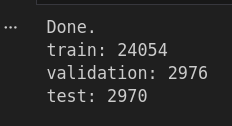
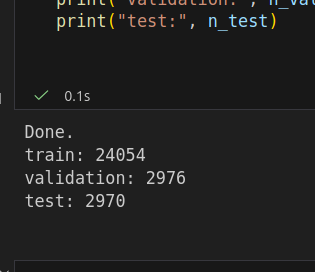